# Visualization with `Polarplot`

This notebook shows examples of how to use `Polarplot` to visualize data. `Polarplot` is useful for showing data in a polar coordinate system, and has axis coordinates defined in latitude and local time. Here, we use it to plot in a magnetic latitude and magnetic local time (MLT) system.

In this notebook we will:
1. Set up a local `CSgrid` that is offset from the North Pole and rotated.
2. Initiate `Polarplot` objects - polar axes (MLAT/MLT) - as well as two Cartesian axes for plotting in the `CSgrid` projection ($\xi, \eta$).
3. Plot `coastlines`.
4. `plot` grid and the outline of the grid.
5. Mark the location of the Geographic North Pole with `scatter` and `text`.
6. Plot the `terminator`.
7. Plot electric equipotentials using `contour`.
8. Plot $\mathbf{E}\times\mathbf{B}$ convection velocity vectors using `quiver`.

Import relevant modules:

In [1]:
%matplotlib inline
import lompe
import apexpy
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.patches import Polygon
from lompe.polplot import Polarplot
from dipole import Dipole

RE = 6371.2e3                   # Earth's radius [m]
HI = 110e3                      # ionospheric altitude [m]
time = dt.datetime(2010, 3, 10) # time for coordinate conversion and coastlines
stencil_size = 1                # size of the stencil used for numerical differentiation
B0 = 3e-5                       # mean magnetic field, assumed to be radial

#### Set up the cubed sphere grid
We set up a cubed sphere grid centered at 88$^{\circ}$W and 72$^{\circ}$N (geographic coordinates, the global system is geographic, see Notebook 01). The grid is 7000$\times$5000 km, rotated 45$^{\circ}$ (towards the north), and set to the ionospheric altitude of 110 km. For illustration purposes, the grid is quite coarse, with a resolution of 200$\times$200 km.

In [2]:
L, W, Lres, Wres = 7000e3, 5000e3, 200e3, 200e3 # [m]
position = (-88, 72)                            # geographic lon, lat of center of grid
orientation = 45                                # angle defining orientation of xi-axis (wrt global northward)
grid = lompe.cs.CSgrid(lompe.cs.CSprojection(position, orientation), L, W, Lres, Wres, R=RE+HI)

#### Set up figure - `Polarplot` axes and `coastlines`

We then set up a figure with panels (A) and (C) having `polplot.Polarplot` polar axes. We set the lower limit, `minlat`, to 50$^{\circ}$ magnetic latitude. Panels (B) and (D) will show the same thing as the (A) and (C) but in the `CSgrid` projection ($\xi$/$\eta$). 

The `Polarplot.coastlines()` method makes it easy to get coastlines on the polar axis. The map will move beneath the fixed MLAT/MLT system during the day as the Earth rotates, and a datetime is required by the `coastlines` method.

The coastlines can be plotted on the grid axis through the class method `CSgrid.projection.get_projected_coastlines()` that returns coastlines projected to the grid coordinates.



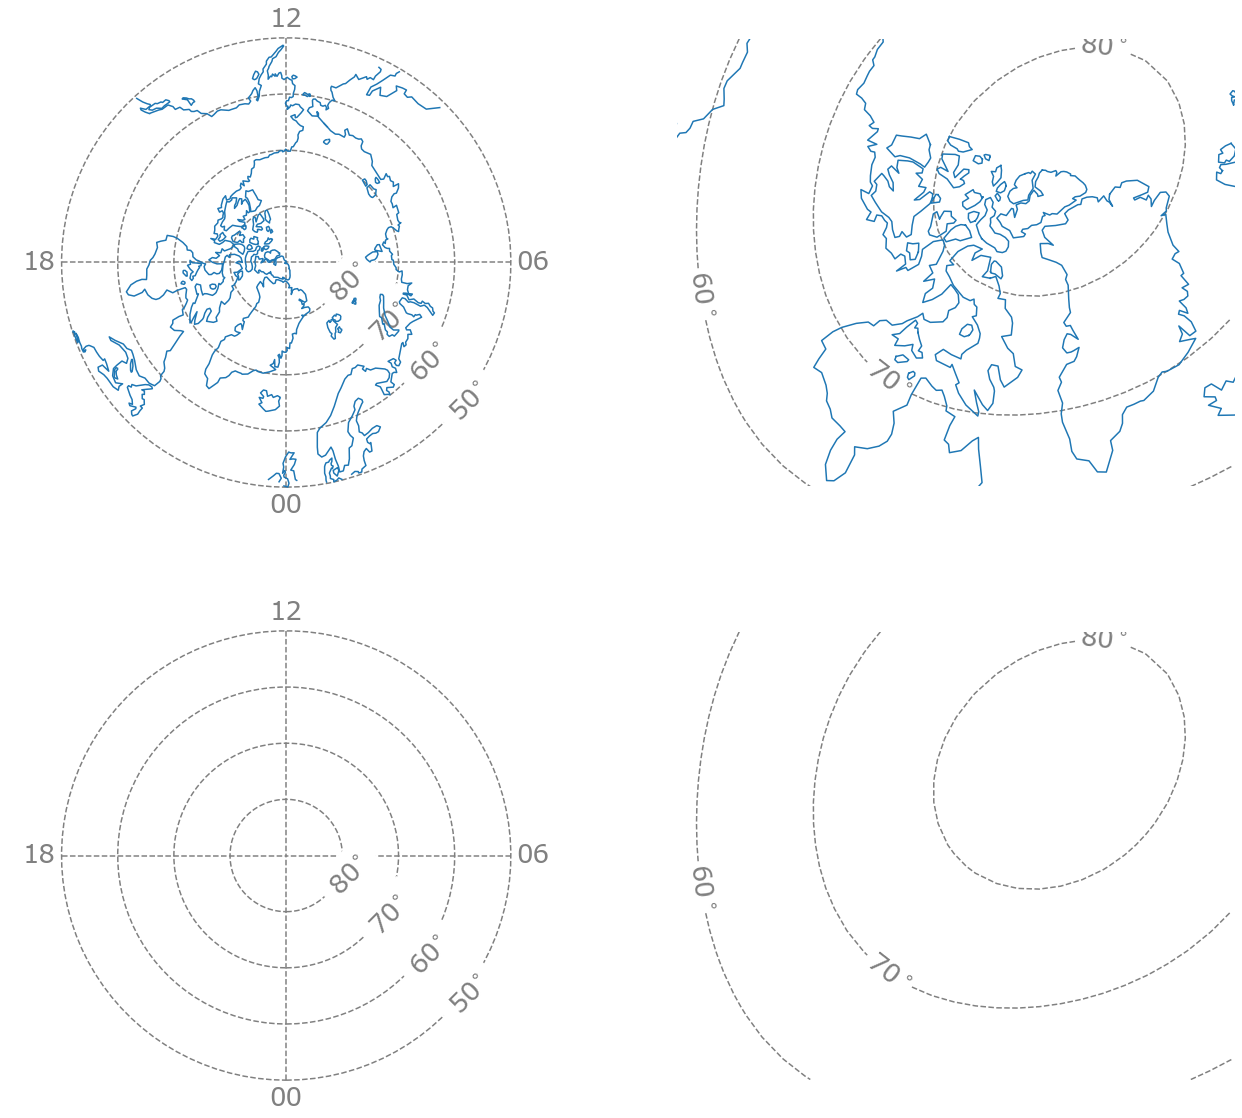

In [3]:
# set up figure and subplots
fig = plt.figure(figsize = (22,20))
axs = {}

axs['grid'  ] = fig.add_subplot(222)
axs['grid2' ] = fig.add_subplot(224)
axs['polar' ] = fig.add_subplot(221)
axs['polar2'] = fig.add_subplot(223)

for key in axs.keys():
    axs[key].set_axis_off()
    axs[key].set_aspect('equal')


# polar axes with MLAT/MLT labels
axs['polar' ] = Polarplot(axs['polar' ], minlat=50, plotgrid=True, linewidth=1.5, color='grey')
axs['polar2'] = Polarplot(axs['polar2'], minlat=50, plotgrid=True, linewidth=1.5, color='grey')
textargs = {'fontsize':26, 'color':'grey'}
axs['polar' ]. writeLTlabels( lat=49, **textargs)
axs['polar2'].writeLTlabels( lat=49, **textargs)
axs['polar' ]. writeLATlabels( lt=3 , **textargs)
axs['polar2'].writeLATlabels( lt=3 , **textargs)

# magnetic latitude contours on grid axes
apex = apexpy.Apex(time, refh=HI*1e-3) 
mlat, mlon = apex.geo2apex(grid.lat_mesh, grid.lon_mesh, height=HI*1e-3)  # grid to MLAT/MLT
latargs = {'linestyles':'--', 'colors':'grey', 'linewidths':1.5, 'levels':np.r_[-80:81:10]}
co =axs['grid' ].contour(grid.xi_mesh, grid.eta_mesh, mlat, **latargs)
co2=axs['grid2'].contour(grid.xi_mesh, grid.eta_mesh, mlat, **latargs)
axs['grid' ].clabel(co,  co.levels, inline = True, fontsize=textargs['fontsize'], fmt='%1.0f$^\circ$')
axs['grid2'].clabel(co2, co.levels, inline = True, fontsize=textargs['fontsize'], fmt='%1.0f$^\circ$')

# adjust limits of grid axes
xlim, ylim = (grid.xi_mesh[0, 0], grid.xi_mesh [-1, -1]+.005), (grid.eta_mesh [0, 0], grid.eta_mesh[-1, -1])
axs['grid' ].set_xlim(xlim)
axs['grid' ].set_ylim(ylim)
axs['grid2'].set_xlim(xlim)
axs['grid2'].set_ylim(ylim)

# coastlines on polar axis
plot_kwargs = {'color':'C0', 'zorder':2}
axs['polar'].coastlines(time=time, mag=apexpy.Apex(time, 0), resolution='110m', **plot_kwargs)

# coastlines on grid axis
for cl in grid.projection.get_projected_coastlines(resolution='110m'):
    axs['grid' ].plot(cl[0], cl[1], **plot_kwargs)


#### `plot`

We wan use standard `plot` methods to show the grid on the `Polarplot` axes. Note that the `Polarplot` methods are very similar to the corresponding built-in `matplotlib.pyplot` methods which are used to visualize data on the grid axes. Plotting arguments that work for the `pyplot`-equivalent can be passed to the `Polarplot` plotting functions (`color`, `linewidth`, `zorder`, etc.).

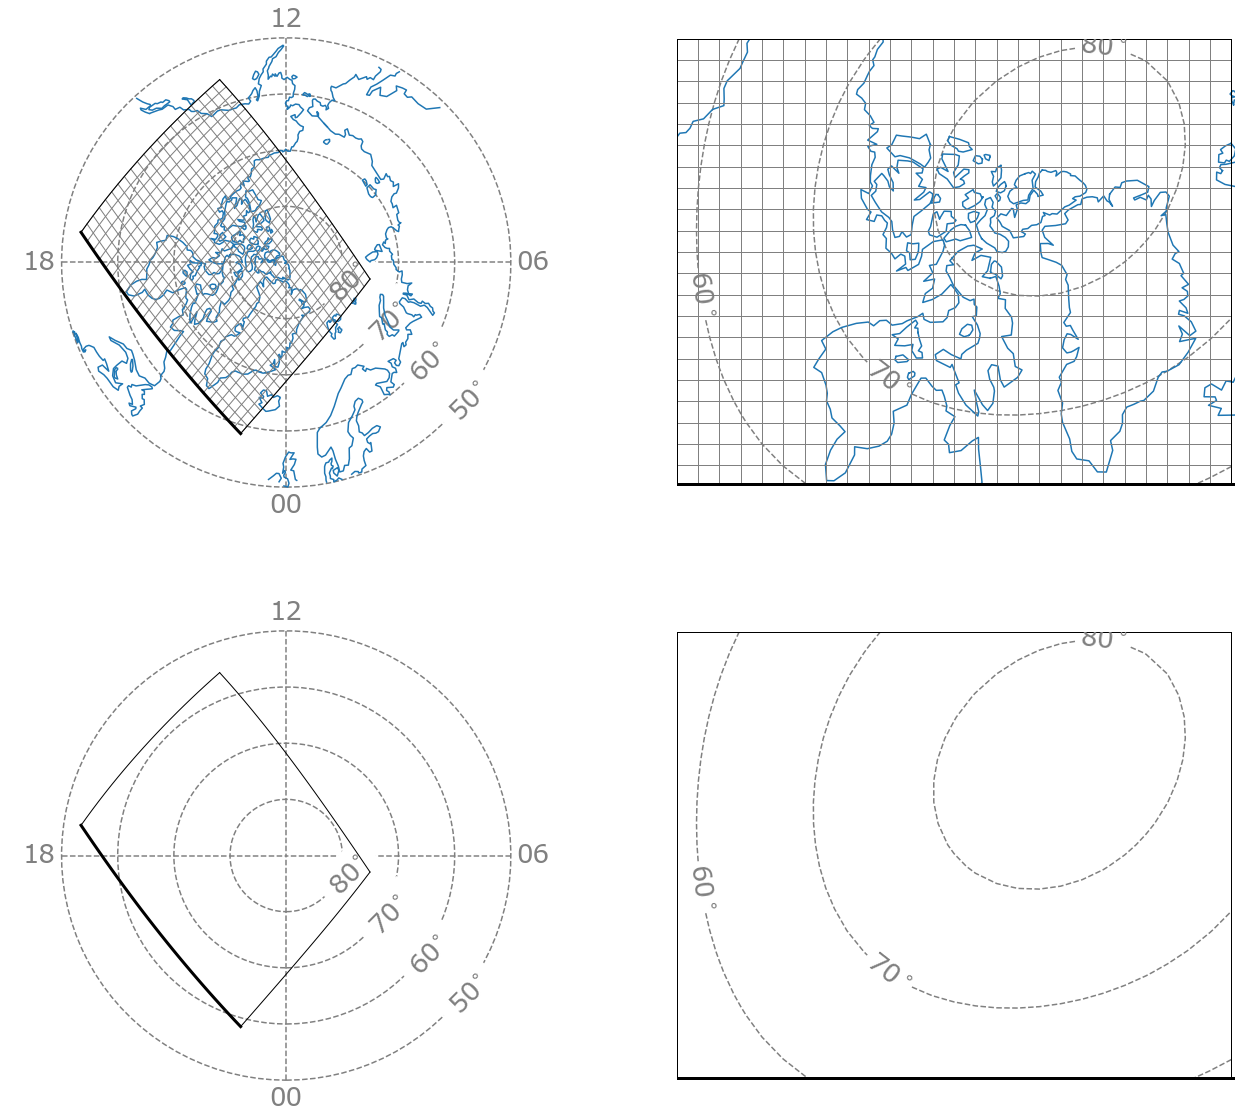

In [4]:
plotargs = {'color':'grey', 'lw':1, 'zorder':2}

# grid cells on polar axis
for lon, lat in grid.get_grid_boundaries():
    mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3) # to MLAT/MLT
    mlt = apex.mlon2mlt(mlon, time)
    axs['polar'].plot(mlat, mlt, **plotargs)

# grid cells on grid axis
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs['grid'].plot(xi, eta, **plotargs)


outlineargs = {'color':'black', 'zorder':2}
# grid outline on polar axis
xs = (grid.lon_mesh[0, :], grid.lon_mesh[-1, :], grid.lon_mesh[:, 0], grid.lon_mesh[:, -1]) # geographic
ys = (grid.lat_mesh[0, :], grid.lat_mesh[-1, :], grid.lat_mesh[:, 0], grid.lat_mesh[:, -1]) # geographic
for i, c in enumerate(zip(xs, ys)):
    lon, lat = c
    mlat, mlon = apex.geo2apex(lat, lon, HI*1e-3)        # to MLAT/MLT coordinates
    mlt = apex.mlon2mlt(mlon, time)
    axs['polar' ].plot(mlat, mlt, linewidth = 3 if i == 0 else 1, **outlineargs) # like plt.plot
    axs['polar2'].plot(mlat, mlt, linewidth = 3 if i == 0 else 1, **outlineargs)

# grid outline on grid axis
xis  = (grid.xi_mesh [0, :], grid.xi_mesh [-1, :], grid.xi_mesh [:, 0], grid.xi_mesh [:, -1]) # grid
etas = (grid.eta_mesh[0, :], grid.eta_mesh[-1, :], grid.eta_mesh[:, 0], grid.eta_mesh[:, -1]) # grid
for i, c in enumerate(zip(xis, etas)):
    xi, eta = c
    axs['grid' ].plot(xi, eta, linewidth = 7 if i == 0 else 1, **outlineargs)
    axs['grid2'].plot(xi, eta, linewidth = 7 if i == 0 else 1, **outlineargs)

fig

#### `scatter` and `text`

We illustrate how the `scatter()` and `text()` functions work for `Polarplot` objects by marking the Geographic North Pole on the axes. Note that the `Polarplot` axes are defined in a magnetic system, and the Geographic North Pole is is offset from the center of the polar axes (the magnetic pole). We also mark the Geographic North Pole on the grid axes.

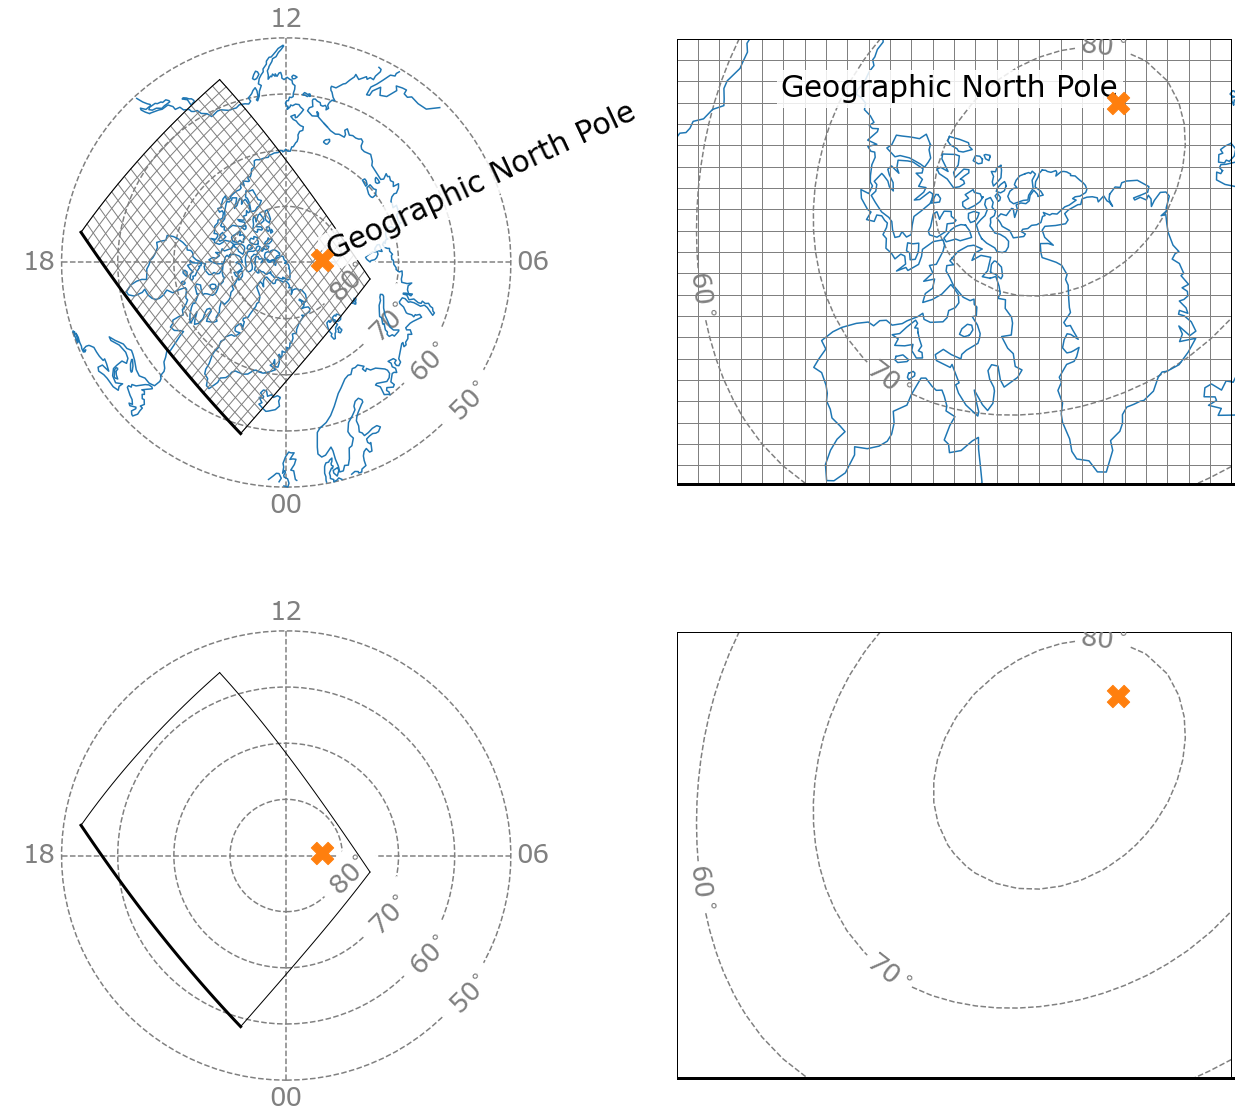

In [5]:
scatdict = {'s':500, 'color':'C1', 'zorder':4, 'marker':'X'}
bboxdict = {'facecolor':'white', 'alpha':.85, 'edgecolor':'white'}

# on polar axis
a = apexpy.Apex(time, refh=0)               # to MLAT/MLT
mlat, mlon = a.geo2apex(90, 0, 0)           
mlt = a.mlon2mlt(mlon, time)
axs['polar' ].text(   mlat, mlt, 'Geographic North Pole', fontsize=30, rotation=25, bbox=bboxdict)   # like plt.text
axs['polar' ].scatter(mlat, mlt, **scatdict)                                                       # like plt.scatter
axs['polar2'].scatter(mlat, mlt, **scatdict)

# on grid axis
xi, eta = grid.projection.geo2cube(0,90)    # grid coordinate of North Pole
axs['grid' ].text(   xi, eta, 'Geographic North Pole', fontsize=30, ha='right', va='bottom', bbox=bboxdict)
axs['grid' ].scatter(xi, eta, **scatdict)
axs['grid2'].scatter(xi, eta, **scatdict)

fig

#### `plot_terminator`

The sunlight terminator can also be plotted using shading or just by a line. `Polarplot.plot_terminator()` plots the terminator line on the polar axis. Since we define our polar axis in magentic apex coordinates, we give an `apexpy` object to the terminator method so that terminator coordinates are converted to magentic. The terminator is by default set to where the solar zenith angle is 90$^\circ$, but can be adjusted using the `sza` keyword. 

For consistency, we manually plot the terminator on the grid projection, using the `utils.sunlight` module to obtain the solar zenith angles.

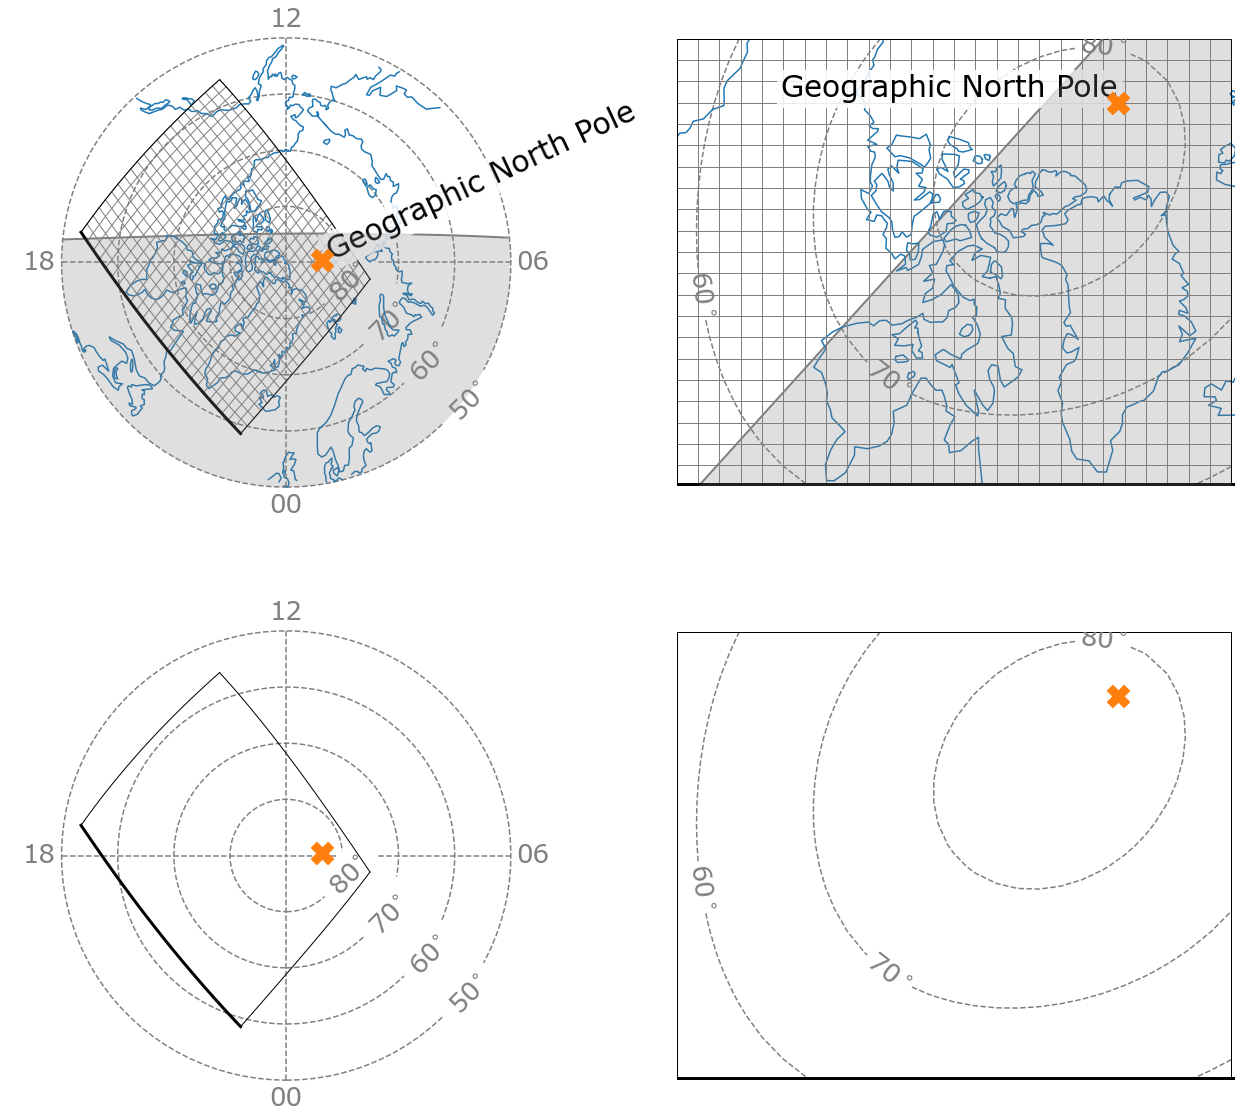

In [6]:
# terminator (sza>=90 deg) on polar axis
shade_kwargs = {'alpha':.25, 'zorder':3}
terminator_kwargs={'color':'grey', 'lw':2, 'zorder':0}
axs['polar'].plot_terminator(time, apex=apex, shadecolor='grey', shade_kwargs=shade_kwargs, **terminator_kwargs)

# terminator on grid axis
szas = lompe.utils.sunlight.sza(grid.lat_mesh, grid.lon_mesh, time).reshape(grid.lat_mesh.shape)

# define polygon for region where sza is >90 deg
minxi, maxxi   = grid.xi_mesh[0][szas[0] >= 90].min(), grid.xi_mesh[szas <= 90].max()
y = [[minxi, grid.eta_mesh.min()], [maxxi, grid.eta_mesh.max()], [grid.xi_mesh.max(), grid.eta_mesh.max()], 
     [grid.xi_mesh.max(), grid.eta_mesh.min()]]
p = Polygon(y, facecolor = 'grey', **shade_kwargs)
axs['grid'].plot([minxi, maxxi], [grid.eta_mesh.min(), grid.eta_mesh.max()], **terminator_kwargs)
axs['grid'].add_patch(p)

fig

#### `contour`

As an example of contours on plots, we use the electric potential, $\Phi$, contours from the empirical [Weimer (2005a](https://doi.org/10.1029/2004JA010884)[,b)](https://doi.org/10.1029/2005JA011270) model, with solar wind velocity 350 km/s, IMF $B_y$ = 0 nT, $B_z=-4$ nT, solar wind density 2 particles per cm$^3$, and dipole tilt angle $25^\circ$ (also seen in, e.g., Notebook 01).

In [7]:
# read potential file
weimer = np.load('./datasets/interpolated_weimer.npz')
Phi = weimer['Phi']
mlatxx = weimer['lat'] # magnetic lat
mlonxx = weimer['lon'] # magnetic lon
mltxx = mlonxx/15 # 0 deg mlat is 00 MLT

We then plot contours on the polar and Cartesian axes using the respective `contour` plotting methods:

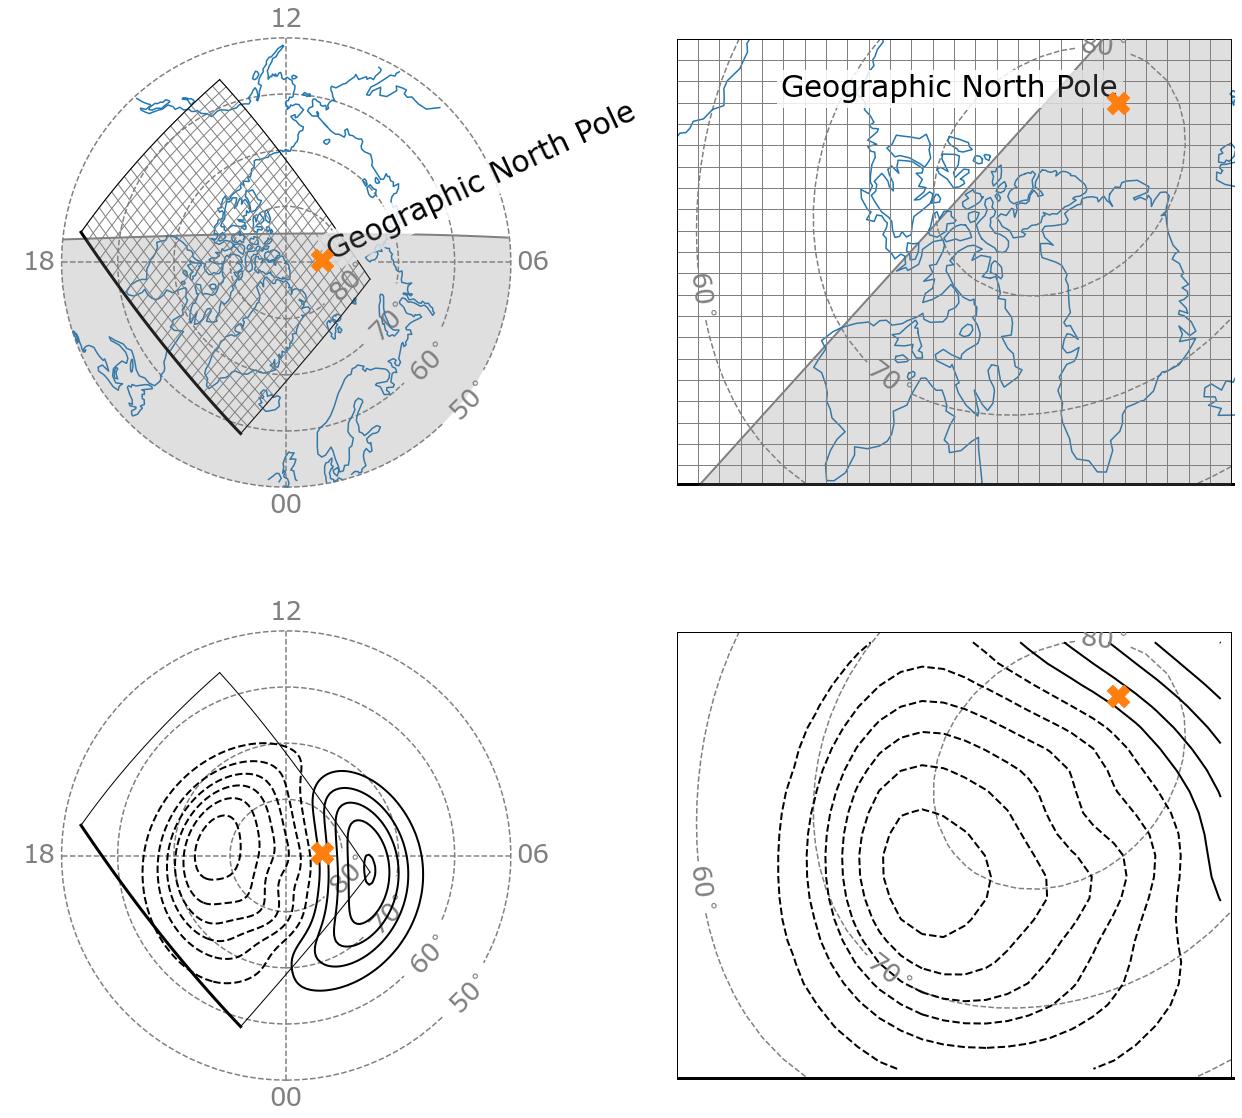

In [8]:
contkwargs = {'levels':np.r_[-45:46:6]*1e3, 'colors':'black', 'linewidths':2, 'zorder':2}

# on polar axis
axs['polar2'].contour(mlatxx, mltxx, Phi, **contkwargs)  # like plt.contour

# on grid axis
mlonxx = apex.mlt2mlon(mltxx, time)
latxx, lonxx, _ = apex.apex2geo(mlatxx, mlonxx, HI*1e-3) # to geographic coordinates
xi, eta = grid.projection.geo2cube(lonxx, latxx)         # to cube coordinates

# interpolate potential to grid and plot
mask = np.isnan(xi) # remove nans
Phi = griddata((xi[~mask].flatten(), eta[~mask].flatten()), Phi[~mask].flatten(), 
                   (grid.xi.flatten(), grid.eta.flatten()), fill_value=0, method='cubic').reshape(grid.shape)
axs['grid2'].contour(grid.xi, grid.eta, Phi, **contkwargs)

fig

Filled contours are plotted using `contourf()`. An example of this is seen in Notebook 04.

#### `quiver`

Vector fields or individual vectors can be plotted using `quiver()`. An example of this is plotting the $\mathbf{E}\times\mathbf{B}$ convection velocity. We use the same approach as in, e.g., Notebook 01 to find the electric field $\mathbf{E}$ described by the Weimer potential.

The $\mathbf{E}\times\mathbf{B}$ convection velocity is:
\begin{equation}
    \mathbf{v}_{\mathrm{E}\times\mathrm{B}} = \frac{\mathbf{E}\times\mathbf{B}}{|\mathbf{B}|^2},
\end{equation}
where $\mathbf{B}$ is the geomagnetic field. Here, we assume a dipole magnetic field (same as in Notebook 02).

In [9]:
# use cubedsphere differentiation matrices to get electric field within grid region
De, Dn = grid.get_Le_Ln(S=stencil_size, return_sparse=True)
E_e = -De.dot(Phi.flatten()).reshape(grid.shape)
E_n = -Dn.dot(Phi.flatten()).reshape(grid.shape)

# apex coordinates of grid
gridmlat, gridmlon = apex.geo2apex(grid.lat, grid.lon, HI*1e-3)   # to MLAT/MLT coordinates
gridmlt = apex.mlon2mlt(gridmlon, time)

E_n[gridmlat < 60] = 0 # set to zero flow at low latitudes

# calculate dipole magnetic field radial components and absolute values
B_r = -2 * B0 * np.sin(gridmlat * np.pi / 180) 
B   =      B0 * np.sqrt(1 + 3 * np.sin(gridmlat * np.pi / 180)**2)

# calulate velocity components 
v_e =  E_n * B_r/B**2
v_n = -E_e * B_r/B**2

We now have the geographic east, north components of the $\mathbf{E}\times\mathbf{B}$ convection velocity. Our `Polarplot` objects require vector input in *magnetic* east, north, and that the grid axis requires vector components in the $\xi$ and $\eta$ directions. We use `apexpy`'s base vectors to rotate $\mathbf{v}_{\mathrm{E}\times\mathrm{B}}$ to the magnetic system, while the rotation to the grid projection is easily done using `CSgrid.projection.vector_cube_projection()`.

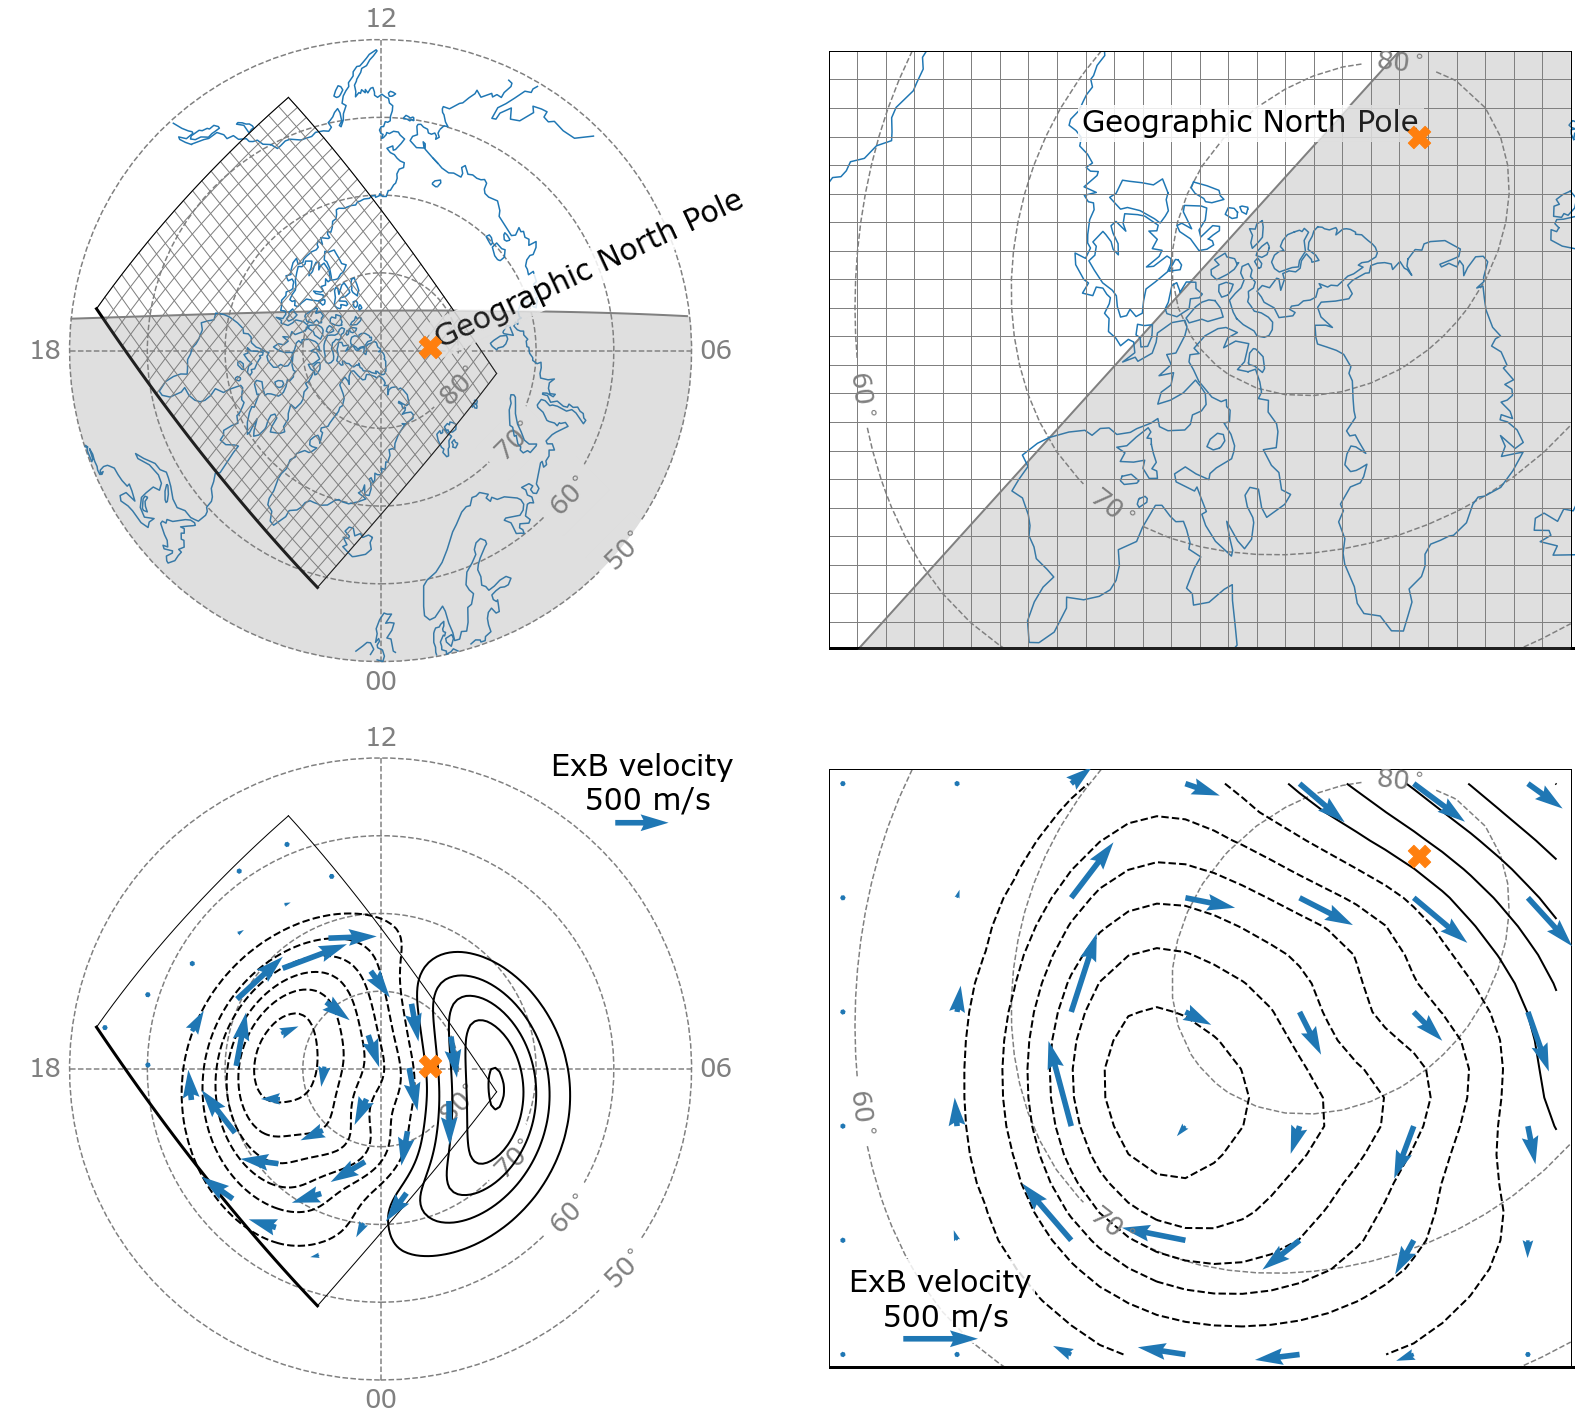

In [10]:
# on polar axis

# rotate vectors to magnetic
f1, f2 = apex.basevectors_qd(grid.lat.flatten(), grid.lon.flatten(), HI*1e-3, coords = 'geo')
v_geo = np.vstack((v_e.flatten(), v_n.flatten()))
v_emag = np.einsum('ij,ij->j', f1, v_geo) # Richmond (1995) equations (7.12) and (7.13) but for velocity vector
v_nmag = np.einsum('ij,ij->j', f2, v_geo) 

# quiver key
qkey = {'X':.85, 'Y':.86, 'U':500, 'label':"ExB velocity\n 500 m/s", 'labelpos':'N', 
        'fontproperties':{'size':30}, 'zorder':3} 
SKIP = 15
axs['polar2'].quiver(gridmlat.flatten()[::SKIP], gridmlt.flatten()[::SKIP], v_nmag[::SKIP], v_emag[::SKIP], 
            qkeyproperties=qkey, scale=7000, color='C0', zorder=2)                          # like plt.quiver

# on grid axis
vxi, veta = grid.projection.vector_cube_projection(v_e.flatten(), v_n.flatten(), 
                                                   grid.lon.flatten(), grid.lat.flatten(), return_xi_eta=False)
vxi, veta = vxi.reshape(grid.shape), veta.reshape(grid.shape)
SKIP = 4
quiv = axs['grid2'].quiver(grid.xi[::SKIP, ::SKIP], grid.eta[::SKIP, ::SKIP], vxi[::SKIP, ::SKIP], 
                           veta[::SKIP, ::SKIP], scale = 5000, color = 'C0', zorder=3)
gridqkwargs = {'X':.15, 'Y':.05}
qkey.update(gridqkwargs)
axs['grid2'].quiverkey(quiv, **qkey)
axs['grid2'].fill_between([-.4,-.19], [-.3], [-.21], edgecolor='face', color='white', zorder=3, alpha=.85)

fig.subplots_adjust(hspace=0.05, wspace=.1, left=0, right=.99, bottom=.016, top=.99)

# save figure
fig.savefig('./output_figures/05Polarplotexample.png')
fig.savefig('./output_figures/05Polarplotexample.pdf')

fig

The panels show:

- **Top row:** A cubed-sphere grid projected on a MLAT/MLT axis showing a region poleward of 50$^\circ$ magentic latitude (left) and in grid coordinates (right). The thick line corresponds to the bottom of the grid. The orange cross marks the Geographic North Pole, and coastlines are shown in blue.

- **Bottom row:** Same axes as top row, but without the coastlines. The orange cross still marks the Geographic North Pole. equipotential electric contours from the Weimer potential is shown in black, with contour intervals of 6 kV. The blue arrows show the $\mathbf{E}\times\mathbf{B}$ velocity given by the electric field described by the Weimer potential assuming a dipole magnetic field.